---
## Forecasting <br> <font size=3.4> Dataset:Airlines+Data.xlsx<br><font size=2>Forecast the Airlines Passengers data set.
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('/Users/Ketan/Data Science/Assignments/Forecasting/Airlines+Data.xlsx')
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [3]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [4]:
df1= df.set_index('Month')
df1

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [5]:
df1.dtypes

Passengers    int64
dtype: object

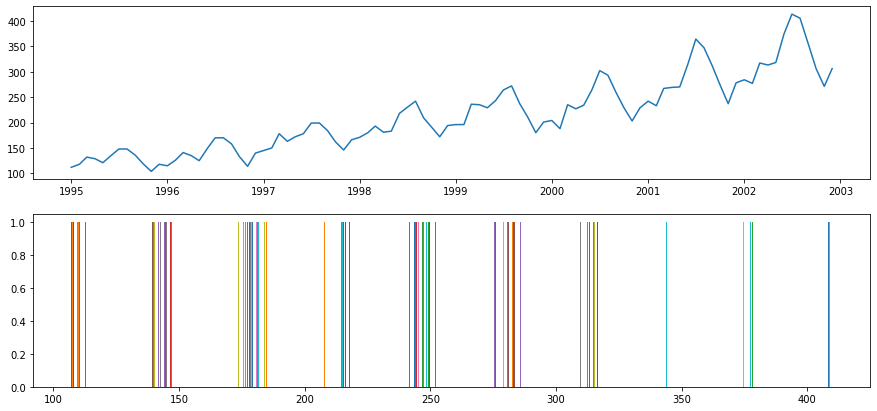

In [6]:
plt.figure(figsize=(15,7))
# line plot
plt.subplot(211)
plt.plot(df1)
# histogram
plt.subplot(212)
plt.hist(df1)
plt.show()

### Square Root Transform

In [7]:
from numpy import sqrt
from pandas import DataFrame

In [8]:
dataframe = DataFrame(df1.values)
dataframe.columns = ['Passengers']
dataframe['Passengers'] = sqrt(dataframe['Passengers'])

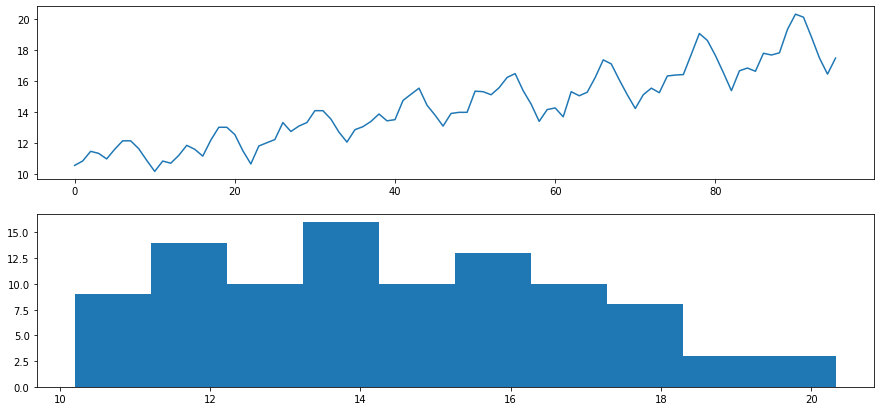

In [9]:
plt.figure(figsize=(15,7))
# line plot
plt.subplot(211)
plt.plot(dataframe['Passengers'])
# histogram
plt.subplot(212)
plt.hist(dataframe['Passengers'])
plt.show()

### Log Transform

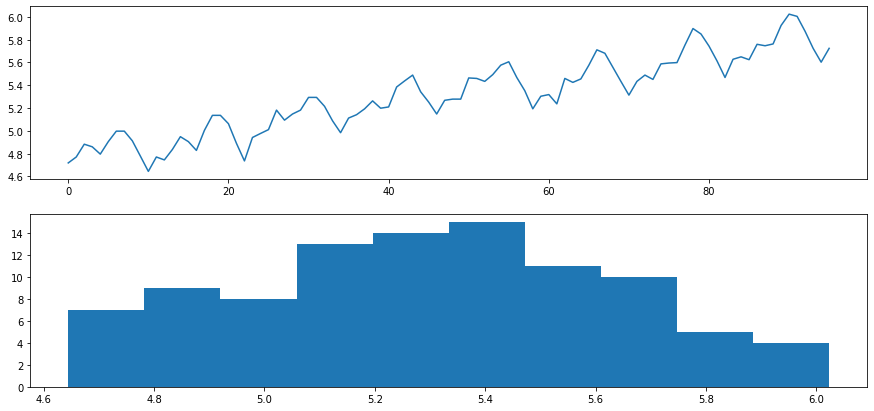

In [10]:
from numpy import log
dataframe = DataFrame(df1.values)
dataframe.columns = ['Passengers']
dataframe['Passengers'] = log(dataframe['Passengers'])

plt.figure(figsize=(15,7))
# line plot
plt.subplot(211)
plt.plot(dataframe['Passengers'])
# histogram
plt.subplot(212)
plt.hist(dataframe['Passengers'])
plt.show()

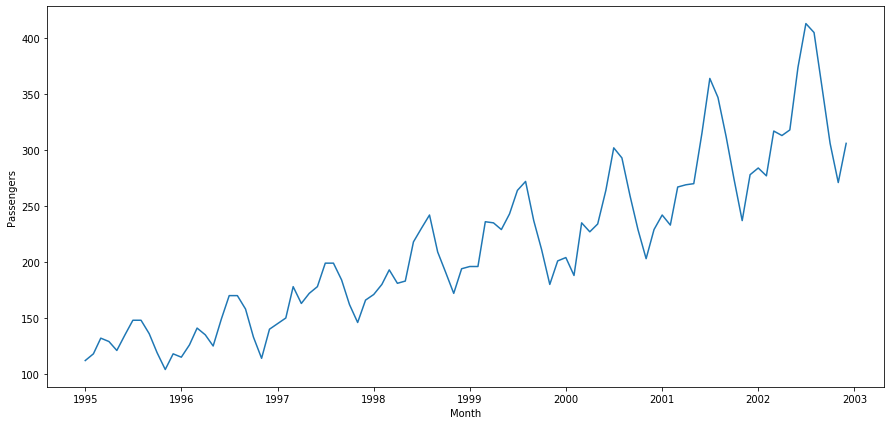

In [11]:
plt.figure(figsize=(15,7))
sns.lineplot(x="Month",y="Passengers",data=df1)

In [12]:
df1["t"] = np.arange(1,97)

df1["t_sq"] = df1["t"]*df1["t"]

df1["log_Passengers"] = np.log(df1["Passengers"])
df1

,Passengers,t,t_sq,log_Passengers
Month,,,,
1995-01-01,112,1,1,4.718499
1995-02-01,118,2,4,4.770685
1995-03-01,132,3,9,4.882802
1995-04-01,129,4,16,4.859812
1995-05-01,121,5,25,4.795791
...,...,...,...,...
2002-08-01,405,92,8464,6.003887
2002-09-01,355,93,8649,5.872118
2002-10-01,306,94,8836,5.723585


In [13]:
Train = df1.head(77)
Test = df1.tail(19)

In [14]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

58.14854431950878

In [15]:
#Exponential

Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

47.889654251840064

In [16]:
#Quadratic 

Quad = smf.ols('Passengers~t+t_sq',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_sq"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

58.92632852818895

In [17]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
1,rmse_Exp,47.889654
0,rmse_linear,58.148544
2,rmse_Quad,58.926329


In [18]:
df2 = df1.iloc[:,0:1]
df2

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [19]:
# separate out a validation dataset
split_point = len(df2) - 10
dataset, validation = df2[0:split_point], df2[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 86, Validation 10


### Persistence/ Base model

In [20]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [21]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

# ARIMA Hyperparameters

In [22]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

### Grid search for p,d,q values

In [23]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [24]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
#evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=78.563
ARIMA(0, 0, 1) RMSE=44.789
ARIMA(0, 1, 0) RMSE=25.903
ARIMA(0, 1, 1) RMSE=25.355
ARIMA(0, 1, 2) RMSE=27.772
ARIMA(0, 1, 3) RMSE=23.806
ARIMA(0, 1, 4) RMSE=22.640
ARIMA(0, 2, 0) RMSE=32.474
ARIMA(0, 2, 1) RMSE=26.640
ARIMA(0, 2, 2) RMSE=25.942
ARIMA(1, 0, 0) RMSE=26.036
ARIMA(1, 0, 1) RMSE=25.282
ARIMA(1, 0, 2) RMSE=436.542
ARIMA(1, 1, 0) RMSE=25.679
ARIMA(1, 2, 0) RMSE=31.603
ARIMA(2, 0, 0) RMSE=25.620
ARIMA(2, 1, 0) RMSE=25.467
ARIMA(2, 2, 0) RMSE=30.414
ARIMA(3, 0, 0) RMSE=25.510
ARIMA(3, 0, 1) RMSE=24.892
ARIMA(3, 1, 0) RMSE=25.648
ARIMA(3, 2, 0) RMSE=30.597
ARIMA(4, 0, 0) RMSE=25.764
ARIMA(4, 1, 0) RMSE=25.344
ARIMA(4, 2, 0) RMSE=29.205
ARIMA(4, 2, 1) RMSE=26.016
Best ARIMA(0, 1, 4) RMSE=22.640


### Build Model based on the optimized values¶

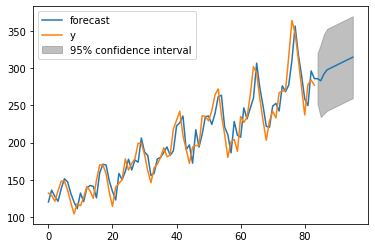

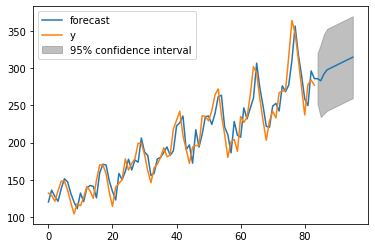

In [25]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

# fit model
model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 96)

In [26]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

59.81126953281223

### Combine train and test data and build final model

In [27]:
# fit model
df = pd.read_excel('/Users/lalitmehendiratta/Downloads/Data Science/Assignments/18. Forecasting/Airlines+Data.xlsx')
df1= df.set_index('Month')

# prepare data
X = df1.values
X = X.astype('float32')

In [28]:
model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()

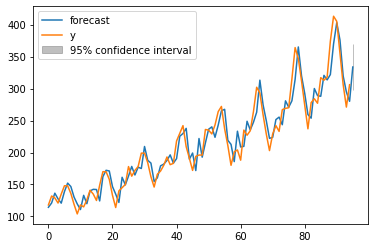

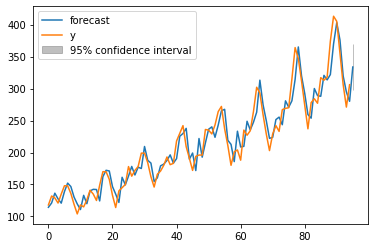

In [29]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,96)

In [30]:
forecast

array([333.64542055, 338.10561879, 344.47640949, 334.99092023,
       337.34157651, 339.69223279, 342.04288907, 344.39354535,
       346.74420163, 349.09485792])